# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

In [ ]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("../src"))
from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from sentence_transformers import SentenceTransformer
from shared.utils import experiment, chamfer, load_and_prepare_beir_dataset

# Initialize Params
# ^ can maybe reduce with PCA if we want
n = 10                                 # number of documents
l = 10                                  # trees per forest
k = 10                                  # pivots to keep per node in tree
km = 15                                 # max depth of each tree
a = 10                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)
distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, k=k, km=km, a=a)

# Set the dataset name (e.g., "msmarco" or "hotpotqa")
dataset = "hotpotqa"  # NOTE hotpotqa is the wikipedia dataset

# vectors (shape(n, m, pca_dims)), queries (shape(m, pca_dims)) = embedded data
# corpus, query = raw text
# d = length of vectors (768)
# q = length of query (min_q)
vectors, queries, corpus, query, d, q = load_and_prepare_beir_dataset(
    dataset=dataset,
    n=n,           # Number of longest documents
    min_m=200,        # Minimum number of words per document -- will attempt this, don't set too high
    min_q = 15,       # Minimum number of words per query -- will try to find exact match
    pca_dims=25,
    split="test",     # Split type
    save_encoded=True # Save the encoded vectors
)
print(d)

# Baseline
best = (0, 0)
for document, doc_vecs in enumerate(vectors):
        sim = chamfer(queries, doc_vecs)
        if sim >= best[0]:
                best = (float(sim), document)
print(best)

def simple_approximate_best(forests: list[LSHForest], queries, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for document, forest in enumerate(forests):
                for i, query in enumerate(queries):
                        idx = forest.query(query, a, dist=distance)[0][0]
                        matches[document, i] = forest.data[idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc

def multidoc_approximate_best(forest: MultiDocLSHForest, queries, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for i, query in enumerate(queries):
                results = forest.query(query, a, dist=distance)
                for document, result in enumerate(results):
                        idx, _ = result[0]
                        matches[document, i] = forest.data[document][idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc


C:\Users\keemi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\beir\util.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Using model: sentence-transformers/multi-qa-mpnet-base-dot-v1 for dataset: hotpotqa
Looking for raw corpus and query data.
Raw corpus and query data found. Loading from local files.
Selected query with 15 words: "Look At Us Now" is a song by American DJs based in which city ?
Embedding corpus and queries
Converting corpus into list of text
Setting vectors per document (m) to 678
Encoding documents
Encoding the query
Data loading and encoding complete. Found 10 document vectors of shape (10, 678, 25) and query vector of shape (15, 25).
25
(104.00819396972656, 9)


In [6]:
from shared.plotting import plot, plot_similarity_heatmap
from shared.utils import experiment_rec, build_rec_forest, query_rec, recall_rec
import matplotlib.pyplot as plt

experiments = {
        'l':  [1, 4, 8, 16, 32],
        #'k':  [4, 8, 16, 32, 64],
        #'km': [16, 32, 64, 128, 256],
        #'a':  [1, 4, 8, 16, 32]
}

# Evaluate single-doc
forest_type = "simple"
results = {}
for var, vals in experiments.items():
    processed_vectors = np.concatenate([doc for doc in vectors])
    #median_ranks, mean_ranks = experiment_rec(var, vals, defaults, processed_vectors, queries, d)
    #print(f"Median ranks for {var} sweep: {median_ranks}")
    #print(f"Mean ranks for {var} sweep: {mean_ranks}")
    
    # Test case 2: Recall test
    print("\nTest Case 2: Recall test")
    forest = build_rec_forest(
        vectors=processed_vectors,
        l=10,  # Using middle value from l sweep
        km=defaults['km'],
        d=d,
        max_split_ratio=5.0,
        max_hash_attempts=10
    )
    
    # Calculate true nearest neighbors here only for the first query from query vector
    query = queries[0] 
    true_dists = np.linalg.norm(processed_vectors - query, axis=1)
    true_nn = np.argsort(true_dists)[:100]  # Top 100 true nearest neighbors
    
    # Get approximate nearest neighbors
    approx_nn = query_rec(forest, query, max_candidates=100, k=100)
    
    # Calculate recall
    recall_score = recall_rec(true_nn, approx_nn, k=100)
    print(f"Recall@100: {recall_score:.2f}")



Test Case 2: Recall test
Recall@100: 0.48


multidoc_approximate_best took 0.0762 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.1377 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2405 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.4277 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.6977 sec, 375 vector comparisons (approx)

Finished experiment: l


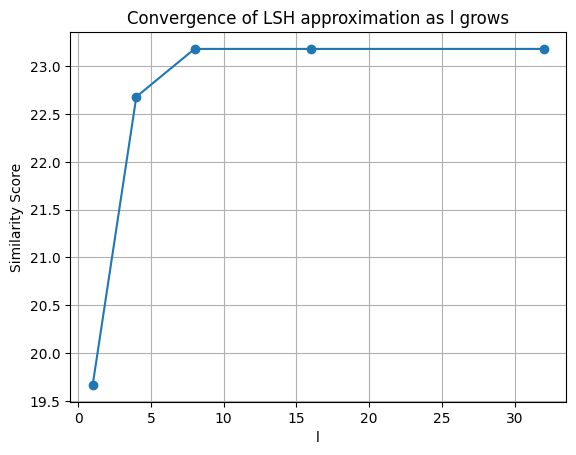

Best l = 8 → doc #1


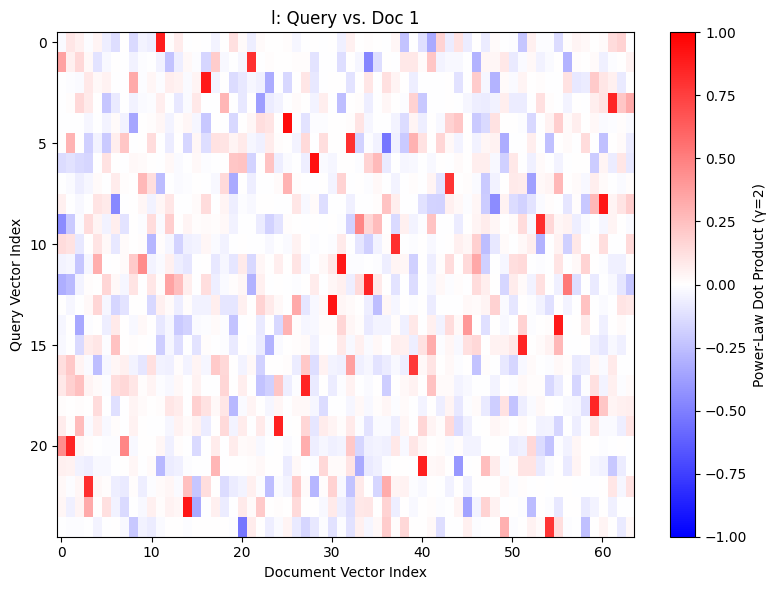

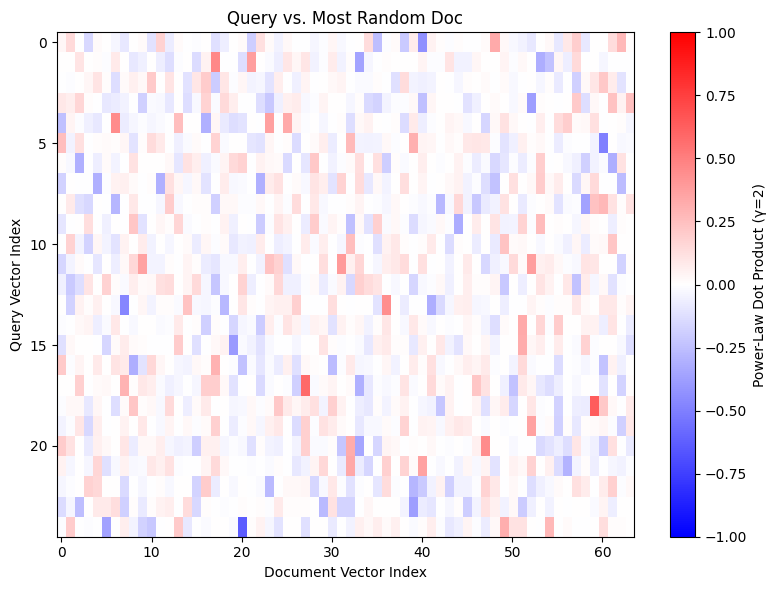

multidoc_approximate_best took 0.2844 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2289 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2364 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2585 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2274 sec, 375 vector comparisons (approx)

Finished experiment: k


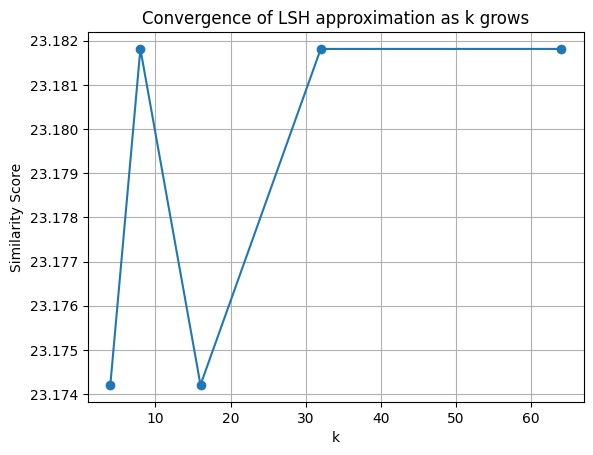

Best k = 8 → doc #1


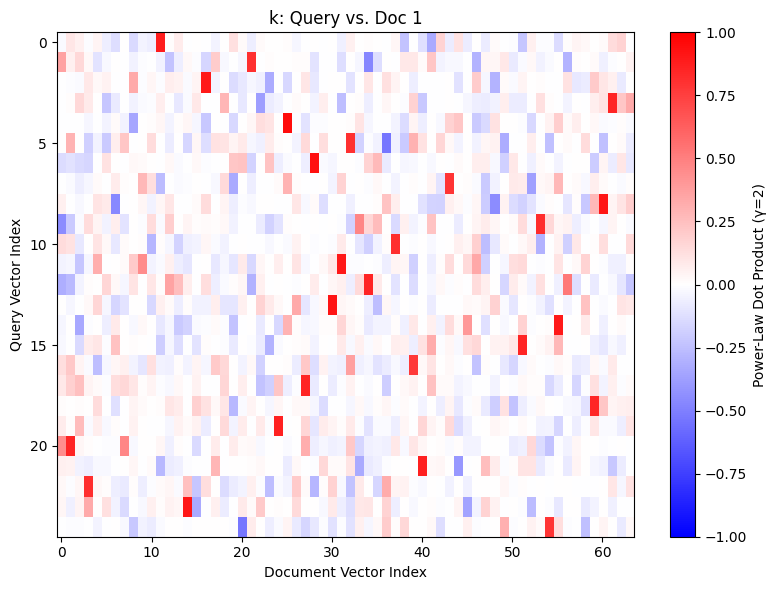

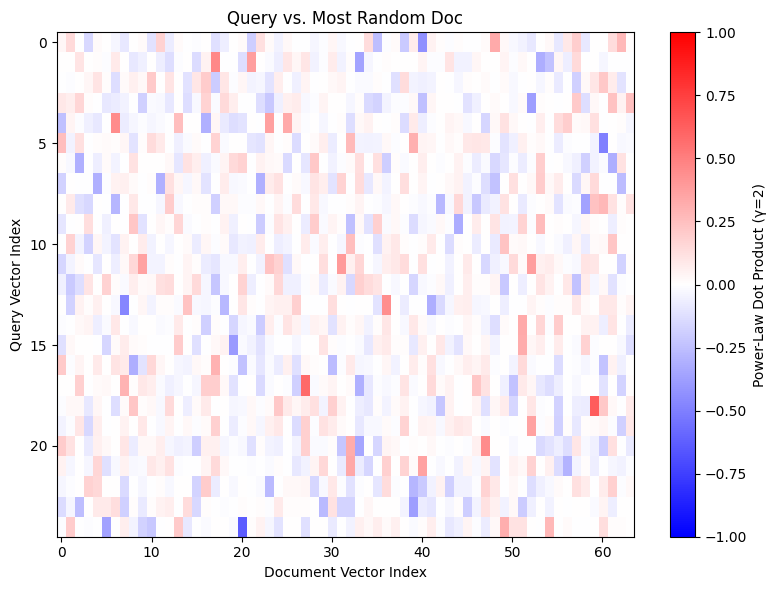

multidoc_approximate_best took 0.1659 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2116 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2339 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2343 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 4.8573 sec, 375 vector comparisons (approx)

Finished experiment: km


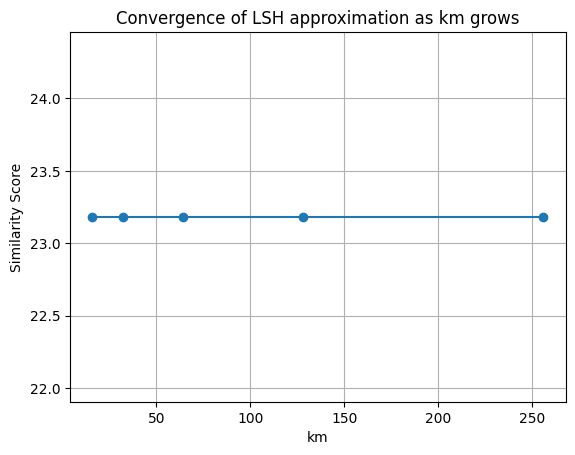

Best km = 16 → doc #1


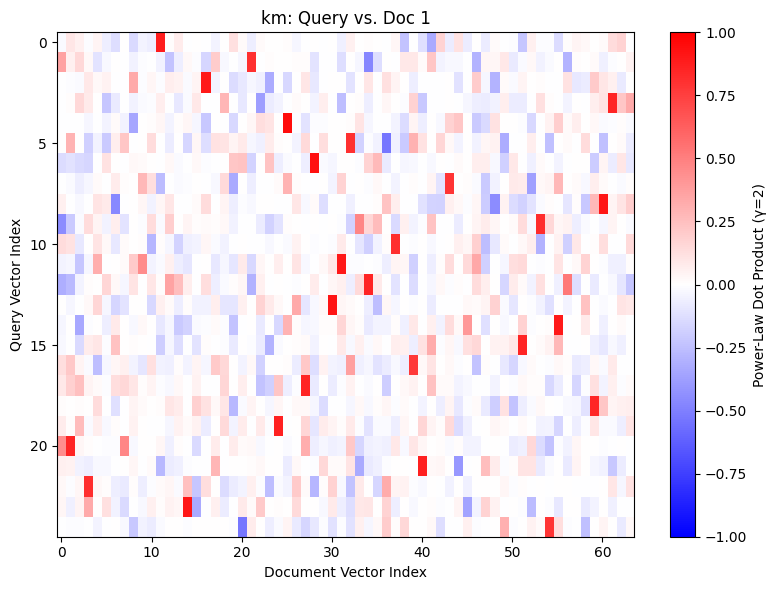

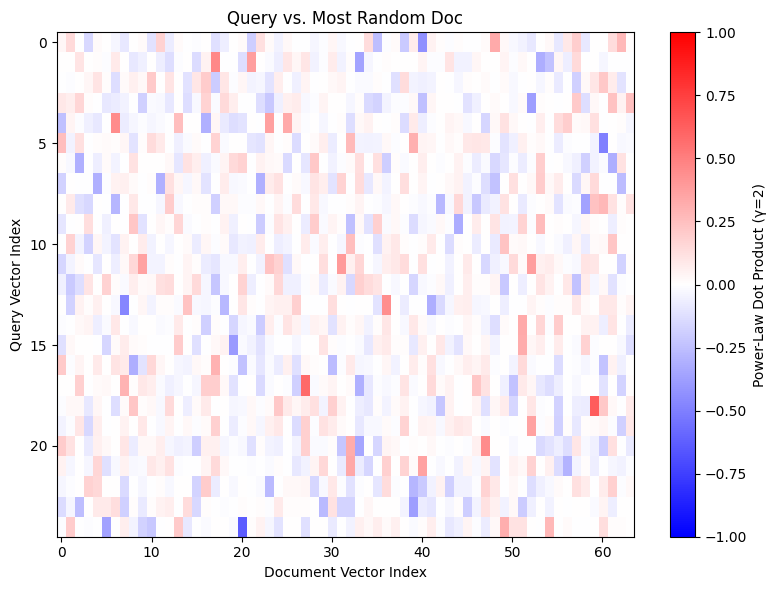

In [ ]:

# Evaluate multi-doc
results = {}
for var, vals in experiments.items():
    sims, docs = experiment(var, vals, defaults, 'multidoc', multidoc_approximate_best, vectors, queries, d)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, vectors[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")
    plot_similarity_heatmap(queries, vectors[-1], f"Query vs. Most Random Doc")

sims = [chamfer(queries, doc) for doc in vectors]
plt.plot(sims)
plt.xlabel("Document ID")
plt.ylabel("Chamfer Similarity")
plt.title("True similarity vs. document index")
plt.grid(True)
plt.show()
